In [1]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

/home/eele/miniconda3/envs/id2223/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/196773
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select([
'alcohol'
'density',
'volatile_acidity',
'chlorides', 'quality'])
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from Wine dataset",
                                  labels=["quality"],
                                  query=query)

In [4]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)
# select didn't work, so we needed to do it manually
X_train = X_train[['alcohol', 'density', 'volatile_acidity', 'chlorides']]
X_test = X_test[['alcohol', 'density', 'volatile_acidity', 'chlorides']]

Finished: Reading data from Hopsworks, using ArrowFlight (1.27s) 


In [5]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.svm import SVC
model = SVC()
param_grid = {'C': uniform(0.1, 100),    
            'gamma': ["scale", "auto"],
            }

rand_search = RandomizedSearchCV(model, param_grid, cv=3, scoring='accuracy', n_iter=10, random_state=5)
rand_search.fit(X_train, y_train.values.ravel())
print(f"Best params: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")
model = rand_search.best_estimator_



Best params: {'C': 44.23092228959531, 'gamma': 'auto'}
Best score: 0.5329566854990584


In [6]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
param_grid = {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],    
            'max_features': ['sqrt', 'log2'],
            'max_depth' : [4,5,6,7,8],
            'criterion' :['gini', 'entropy']
            }

rand_search = RandomizedSearchCV(model, param_grid, cv=3, scoring='accuracy', n_iter=10, random_state=5)
rand_search.fit(X_train, y_train.values.ravel())
print(f"Best params: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")
model = rand_search.best_estimator_

Best params: {'n_estimators': 500, 'max_features': 'log2', 'max_depth': 6, 'criterion': 'entropy'}
Best score: 0.5461393596986817


In [9]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=6, criterion='entropy')
model = model.fit(X_train, y_train.values.ravel())

In [10]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [11]:
print(metrics)

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 41}, '5': {'precision': 0.5907692307692308, 'recall': 0.553314121037464, 'f1-score': 0.5714285714285715, 'support': 347}, '6': {'precision': 0.510670731707317, 'recall': 0.7142857142857143, 'f1-score': 0.5955555555555555, 'support': 469}, '7': {'precision': 0.5185185185185185, 'recall': 0.24705882352941178, 'f1-score': 0.3346613545816733, 'support': 170}, '8': {'precision': 1.0, 'recall': 0.03225806451612903, 'f1-score': 0.0625, 'support': 31}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, 'accuracy': 0.5362182502351834, 'macro avg': {'precision': 0.3742797829992952, 'recall': 0.22098810333838845, 'f1-score': 0.22344935450940004, 'support': 1063}, 'weighted avg': {'precision': 0.5302442562519312, 'recall': 0.5362182502351834, 'f1-score': 0.5046389464912082, 'support': 1063}}


In [12]:
cols = [k for k in metrics.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
true_cols = [f"True {k}" for k in cols]
pred_cols = [f"Pred {k}" for k in cols]

In [13]:
# print f1 score
print(metrics['weighted avg']['f1-score'])

# print accuracy
print(metrics['accuracy'])

0.5046389464912082
0.5362182502351834


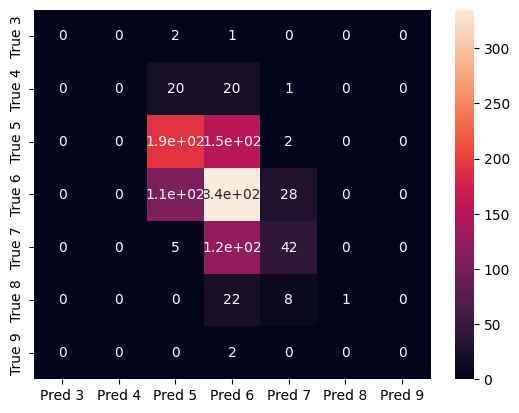

In [14]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, true_cols, pred_cols)
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [15]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 18328497/18328497 elapsed<00:12 remaining<00:0043it/s]
Uploading: 100.000%|██████████| 28420/28420 elapsed<00:02 remaining<00:001,  3.43it/s]
Uploading: 100.000%|██████████| 472/472 elapsed<00:00 remaining<00:00<00:37,  9.36s/it]
Model export complete: 100%|██████████| 6/6 [00:22<00:00,  3.76s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/196773/models/wine_model/1


Model(name: 'wine_model', version: 1)